<h2 align= 'center'><b>TRAINING MODELS</b></h2>

#### **IMPORTING THE LIBRARIES**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#### **IMPORTING THE DATASET**

In [68]:
!pip install xlrd>=2.0.1

In [2]:
# loading encoded data and  naming it as data1

data1= pd.read_csv("E:\Employees_performance_analysis\src\models\data_encoded.csv")
data1

Age  Gender  DistanceFromHome  EmpEducationLevel  \
0      32    True                10                  3   
1      47    True                14                  4   
2      40    True                 5                  4   
3      41    True                10                  4   
4      60    True                16                  4   
...   ...     ...               ...                ...   
1195   27   False                 3                  1   
1196   37    True                10                  2   
1197   50    True                28                  1   
1198   34   False                 9                  3   
1199   24   False                 3                  2   

      EmpEnvironmentSatisfaction  EmpHourlyRate  EmpJobInvolvement  \
0                              4             55                  3   
1                              4             42                  3   
2                              4             48                  2   
3                              2             73                  2   
4                              1             84                  3   
...                          ...            ...                ...   
1195                           4             71                  4   
1196                           4             80                  4   
1197                           4             74                  4   
1198                           4             46                  2   
1199                           1             65                  3   

      EmpJobLevel  EmpJobSatisfaction  NumCompaniesWorked  ...  \
0               2                   4                   1  ...   
1               2                   1                   2  ...   
2               3                   1                   5  ...   
3               5                   4                   3  ...   
4               2                   1                   8  ...   
...           ...                 ...                 ...  ...   
1195            2                   4                   1  ...   
1196            1                   4                   3  ...   
1197            1                   3                   1  ...   
1198            3                   2                   1  ...   
1199            2                   3                   9  ...   

      EmpJobRole_Research Director  EmpJobRole_Research Scientist  \
0                            False                          False   
1                            False                          False   
2                            False                          False   
3                            False                          False   
4                            False                          False   
...                            ...                            ...   
1195                         False                          False   
1196                         False                          False   
1197                         False                          False   
1198                         False                          False   
1199                         False                          False   

      EmpJobRole_Sales Executive  EmpJobRole_Sales Representative  \
0                           True                            False   
1                           True                            False   
2                           True                            False   
3                          False                            False   
4                           True                            False   
...                          ...                              ...   
1195                        True                            False   
1196                       False                            False   
1197                       False                            False   
1198                       False                            False   
1199                        True                            False   

      EmpJobRole_

#### **FEATURES SELECTION**

##### **CHECKING PEARSON'S CORRELATION COEFFICIENT**

In [3]:
# fetching only continuous columns
# considering the previous assumption made in data exploratory part such that features with >=20 unique values are taken as continuous features
for column in data1.columns:
    if data1[column].nunique() >= 20:
        print(f'{column}: {data1[column].nunique()}')
        print("===================================================")              

Age: 43
DistanceFromHome: 29
EmpHourlyRate: 71
TotalWorkExperienceInYears: 29
ExperienceYearsAtThisCompany: 21


In [4]:
continuous_columns= data1[['Age', 'DistanceFromHome', 'EmpHourlyRate', 'TotalWorkExperienceInYears', 'ExperienceYearsAtThisCompany']]

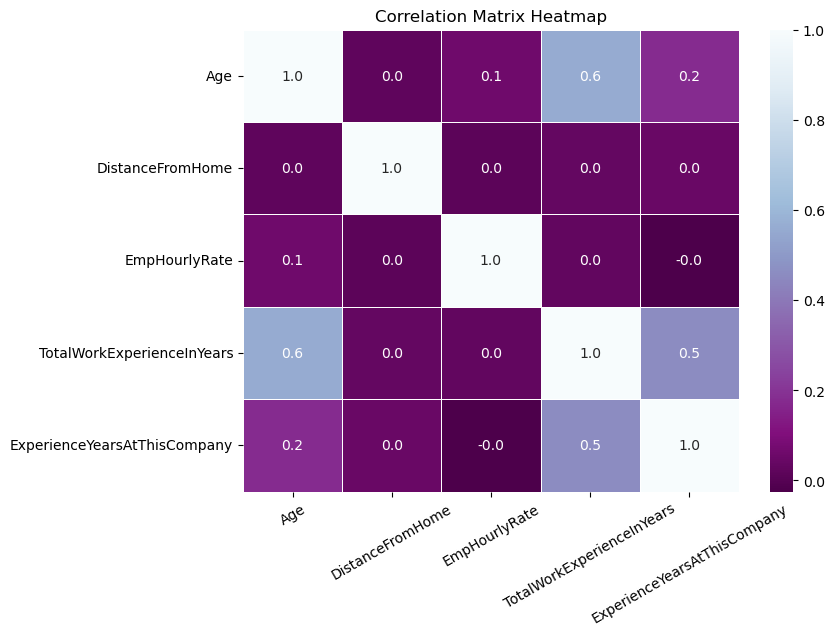

In [5]:
correlation_matrix = continuous_columns.corr()

# Creating a heatmap
plt.figure(figsize=(8, 6))
h= sns.heatmap(correlation_matrix, annot=True, cmap="BuPu_r", fmt=".1f", linewidths=0.5)
h.set_xticklabels(h.get_xticklabels(), rotation= 30)
plt.title("Correlation Matrix Heatmap")
plt.show()

##### Insights:
- All the continuous input features have less multi-collinearity among each other.
- Only the features **"TotalWorkExperienceInYears" and "Age"** are showing slightly higher correlation of above 0.5.
- So one of them could be removed, but **it would be better to consider their correlation with the target variable** before dropping of these features. 

##### **ANOVA TEST**

##### (Between continuous predictors and the categorical target variable)

In [6]:
# Defining a function to find the statistical relationship between target and the continuous input variables

def Anova(data, target, input_features):
  from scipy.stats import f_oneway

  # creating empty list to store the final selected input feaatures
  selected_input_features= []

  for column in input_features:
    features_group_list= data1.groupby(target)[column].apply(list)
    anova_result= f_oneway(*features_group_list)

    # If anova p-value is <0.05, we reject H0 and hence it will be taken as significant feature.

    if anova_result[1] < 0.05:
      print(f'- {column} IS CORRELATED with the {target}| p-value: {anova_result[1]}')
      print("==================================================================================================")
      selected_input_features.append(column)
    else:
      print(f'- {column} IS NOT CORRELATED with {target}| p-value: {anova_result[1]}')
      print("==================================================================================================")

  return(selected_input_features)

In [7]:
# calling the function to check which continuous variables are correlated with the target

print("ANOVA RESULTS:\n")
Anova(data1, 'PerformanceRating', input_features= ['Age', 'DistanceFromHome', 'EmpHourlyRate', 'TotalWorkExperienceInYears', 'ExperienceYearsAtThisCompany'])

ANOVA RESULTS:

- Age IS NOT CORRELATED with PerformanceRating| p-value: 0.3150808268898886
- DistanceFromHome IS NOT CORRELATED with PerformanceRating| p-value: 0.2786929213897704
- EmpHourlyRate IS NOT CORRELATED with PerformanceRating| p-value: 0.23633206407690707
- TotalWorkExperienceInYears IS CORRELATED with the PerformanceRating| p-value: 0.0028670488207405654
- ExperienceYearsAtThisCompany IS CORRELATED with the PerformanceRating| p-value: 3.8123602402513167e-06


['TotalWorkExperienceInYears', 'ExperienceYearsAtThisCompany']

#### Insights:
- From the ANOVA  test, it is clear that among the continous predictors, only **TotalWorkExperienceInYears** and **ExperienceYearsAtThisCompany** are in high correlation with the target variable.
- Hence, columns like **Age, DistanceFromHome, EmpHourlyRate** are not correlated with the target variable.
- Hence these could be dropped.

##### **CHI-SQUARE TEST**

#### Between categorical predictors and the categorical target variable

In [8]:
# categorical_columns= discrete_features + binary_features + nominal_features 

In [9]:
len(data1.columns) # total number of columns

54

In [10]:
continuous_columns.columns # only these five features are continuous columns and the remaining input features come under categorical columns

Index(['Age', 'DistanceFromHome', 'EmpHourlyRate',
       'TotalWorkExperienceInYears', 'ExperienceYearsAtThisCompany'],
      dtype='object')

In [11]:
categorical_columns= data1[['Gender', 'EmpEducationLevel', 'EmpEnvironmentSatisfaction', 'EmpJobInvolvement', 'EmpJobLevel',
                            'EmpJobSatisfaction', 'NumCompaniesWorked', 'OverTime', 'EmpLastSalaryHikePercent', 'EmpRelationshipSatisfaction',
                            'TrainingTimesLastYear', 'EmpWorkLifeBalance','ExperienceYearsInCurrentRole', 'YearsSinceLastPromotion','YearsWithCurrManager',
                            'Attrition', 'PerformanceRating', 'EducationBackground_Life Sciences', 'EducationBackground_Marketing','EducationBackground_Medical',
                            'EducationBackground_Other', 'EducationBackground_Technical Degree', 'MaritalStatus_Married', 'MaritalStatus_Single', 'EmpDepartment_Development',
                            'EmpDepartment_Finance', 'EmpDepartment_Human Resources', 'EmpDepartment_Research & Development', 'EmpDepartment_Sales','EmpJobRole_Data Scientist',
                            'EmpJobRole_Delivery Manager', 'EmpJobRole_Developer', 'EmpJobRole_Finance Manager', 'EmpJobRole_Healthcare Representative', 'EmpJobRole_Human Resources',
                            'EmpJobRole_Laboratory Technician', 'EmpJobRole_Manager', 'EmpJobRole_Manager R&D', 'EmpJobRole_Manufacturing Director', 'EmpJobRole_Research Director', 
                            'EmpJobRole_Research Scientist', 'EmpJobRole_Sales Executive', 'EmpJobRole_Sales Representative', 'EmpJobRole_Senior Developer', 'EmpJobRole_Senior Manager R&D',
                            'EmpJobRole_Technical Architect', 'EmpJobRole_Technical Lead', 'BusinessTravelFrequency_Travel_Frequently', 'BusinessTravelFrequency_Travel_Rarely']]
len(categorical_columns.columns)

49

In [12]:
# importing chi2_contingency from scipy.stats
from scipy.stats import chi2_contingency

target = data1['PerformanceRating']

# Constructing a contingency table between each categorical predictor and the target variable
# empty dictionary to store the statistic values
chi2_results = {}

for col in categorical_columns:
    contingency_table = pd.crosstab(categorical_columns[col], target)
    chi2_stat, p_val, dof, expected_freq = chi2_contingency(contingency_table)
    chi2_results[col] = {'Chi-square statistic': chi2_stat, 'p-value': p_val, 'Degrees of freedom': dof}

# Displaying the results for features with p-values less than 0.05
for col, result in chi2_results.items():
    if result['p-value'] < 0.05:
        print(f"Feature: {col}")
        print(f"Chi-square statistic: {result['Chi-square statistic']}")
        print(f"p-value: {result['p-value']}")
        print(f"Degrees of freedom: {result['Degrees of freedom']}")
        print("-===================================================")
    else:
        print(f'Feature: {col} | p-value: {result["p-value"]} > 0.05')
        print('---------------------------------------------------')          


Feature: Gender | p-value: 0.9217557495859275 > 0.05
---------------------------------------------------
Feature: EmpEducationLevel | p-value: 0.3114744353710753 > 0.05
---------------------------------------------------
Feature: EmpEnvironmentSatisfaction
Chi-square statistic: 325.54812593296936
p-value: 2.7264598025505243e-67
Degrees of freedom: 6
-===================================================
Feature: EmpJobInvolvement | p-value: 0.9399863300500411 > 0.05
---------------------------------------------------
Feature: EmpJobLevel | p-value: 0.1768674128646029 > 0.05
---------------------------------------------------
Feature: EmpJobSatisfaction | p-value: 0.06534321929959395 > 0.05
---------------------------------------------------
Feature: NumCompaniesWorked | p-value: 0.7380228598068068 > 0.05
---------------------------------------------------
Feature: OverTime
Chi-square statistic: 11.282450374168816
p-value: 0.0035485181432246523
Degrees of freedom: 2
-=====================

##### Insights:
- So the features having **p-value < 0.05** are as follows:
  - EmpEnvironmentSatisfaction
  - OverTime
  - EmpLastSalaryHikePercent
  - EmpWorkLifeBalance
  - ExperienceYearsInCurrentRole
  - YearsSinceLastPromotion
  - YearsWithCurrManager
  - EducationBackground_Other
  - EmpDepartment_Development
  - EmpDepartment_Finance
  - EmpDepartment_Sales
  - EmpJobRole_Developer
  - EmpJobRole_Finance Manager
  - EmpJobRole_Manager
  - EmpJobRole_Research Scientist
  -  EmpJobRole_Sales Executive
  - PerformanceRating

- The columns with higher p-value:
  - 'Gender', 'EmpEducationLevel', 'EmpJobInvolvement','EmpJobLevel', 'EmpJobSatisfaction', 'NumCompaniesWorked', 'EmpRelationshipSatisfaction', 'TrainingTimesLastYear',
   'Attrition',  'EducationBackground_Life Sciences', 'EducationBackground_Marketing', 'EducationBackground_Medical', 'EducationBackground_Technical Degree', 'MaritalStatus_Married', 'MaritalStatus_Single', 'EmpDepartment_Human Resources', 'EmpDepartment_Research & Development', 'EmpJobRole_Data Scientist', 'EmpJobRole_Delivery Manager', 'EmpJobRole_Healthcare Representative', 'EmpJobRole_Human Resources', 'EmpJobRole_Laboratory Technician', 'EmpJobRole_Manager R&D', 'EmpJobRole_Manufacturing Director', 'EmpJobRole_Research Director', 'EmpJobRole_Sales Representative', 'EmpJobRole_Senior Developer', 'EmpJobRole_Senior Manager R&D', 'EmpJobRole_Technical Architect', 'EmpJobRole_Technical Lead', 'BusinessTravelFrequency_Travel_Frequently', 'BusinessTravelFrequency_Travel_Rarely'

##### **NEW DATA IS CREATED AFTER DROPPING IRRELEVANT AND LESS CORRELATED PREDICTORS**

In [13]:
# data_fs--> data after feature selection

data_fs= data1[['TotalWorkExperienceInYears', 'ExperienceYearsAtThisCompany', 'EmpEnvironmentSatisfaction', 'OverTime', 'EmpLastSalaryHikePercent',
                'EmpWorkLifeBalance', 'ExperienceYearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'EducationBackground_Other',
                'EmpDepartment_Development', 'EmpDepartment_Finance', 'EmpDepartment_Sales', 'EmpJobRole_Developer', 'EmpJobRole_Finance Manager',
                'EmpJobRole_Manager', 'EmpJobRole_Research Scientist', 'EmpJobRole_Sales Executive', 'PerformanceRating']]

data_fs.head()

TotalWorkExperienceInYears  ExperienceYearsAtThisCompany  \
0                          10                            10   
1                          20                             7   
2                          20                            18   
3                          23                             5   
4                          10                             2   

   EmpEnvironmentSatisfaction  OverTime  EmpLastSalaryHikePercent  \
0                           4         0                        12   
1                           4         0                        12   
2                           4         1                        21   
3                           2         0                        15   
4                           1         0                        14   

   EmpWorkLifeBalance  ExperienceYearsInCurrentRole  YearsSinceLastPromotion  \
0                   2                             7                        0   
1                   3                             7                        1   
2                   3                            13                        1   
3                   2                             6                       12   
4                   3                             2                        2   

   YearsWithCurrManager  EducationBackground_Other  EmpDepartment_Development  \
0                     8                      False                      False   
1                     7                      False                      False   
2                    12                      False                      False   
3                     6                      False                      False   
4                     2                      False                      False   

   EmpDepartment_Finance  EmpDepartment_Sales  EmpJobRole_Developer  \
0                  False                 True                 False   
1                  False                 True                 False   
2                  False                 True                 False   
3                  False                False                 False   
4                  False                 True                 False   

   EmpJobRole_Finance Manager  EmpJobRole_Manager  \
0                       False               False   
1                       False               False   
2                       False               False   
3                       False                True   
4                       False               False   

   EmpJobRole_Research Scientist  EmpJobRole_Sales Executive  \
0                          False                        True   
1                          False                        True   
2                          False                        True   
3                          False                       False   
4                          False                        True   

   PerformanceRating  
0                  3  
1                  3  
2                  4  
3                  3  
4                  3

In [14]:
len(data_fs.columns) # so there are 19 columns in the dataset after feature selection

19

In [15]:
# saving this data to a different csv file
data_fs.to_csv('data_fs.csv', index=False)

#### **SCALING**

In [16]:
# creaating a copy of data_fs for scaling
# mm_scaled_data-->MinMax scaled data

mm_scaled_data= data_fs.copy()
mm_scaled_data.head()


TotalWorkExperienceInYears  ExperienceYearsAtThisCompany  \
0                          10                            10   
1                          20                             7   
2                          20                            18   
3                          23                             5   
4                          10                             2   

   EmpEnvironmentSatisfaction  OverTime  EmpLastSalaryHikePercent  \
0                           4         0                        12   
1                           4         0                        12   
2                           4         1                        21   
3                           2         0                        15   
4                           1         0                        14   

   EmpWorkLifeBalance  ExperienceYearsInCurrentRole  YearsSinceLastPromotion  \
0                   2                             7                        0   
1                   3                             7                        1   
2                   3                            13                        1   
3                   2                             6                       12   
4                   3                             2                        2   

   YearsWithCurrManager  EducationBackground_Other  EmpDepartment_Development  \
0                     8                      False                      False   
1                     7                      False                      False   
2                    12                      False                      False   
3                     6                      False                      False   
4                     2                      False                      False   

   EmpDepartment_Finance  EmpDepartment_Sales  EmpJobRole_Developer  \
0                  False                 True                 False   
1                  False                 True                 False   
2                  False                 True                 False   
3                  False                False                 False   
4                  False                 True                 False   

   EmpJobRole_Finance Manager  EmpJobRole_Manager  \
0                       False               False   
1                       False               False   
2                       False               False   
3                       False                True   
4                       False               False   

   EmpJobRole_Research Scientist  EmpJobRole_Sales Executive  \
0                          False                        True   
1                          False                        True   
2                          False                        True   
3                          False                       False   
4                          False                        True   

   PerformanceRating  
0                  3  
1                  3  
2                  4  
3                  3  
4                  3

In [17]:
# fetching only continuous columns for scaling

for column in mm_scaled_data:
    if mm_scaled_data[column].nunique() >= 20:
        print(f'{column}: {mm_scaled_data[column].nunique()}')
        print("============================================")

TotalWorkExperienceInYears: 29
ExperienceYearsAtThisCompany: 21


##### ***Splitting the data into X and y***

In [18]:
# Splitting the data into X and y
X= mm_scaled_data.drop('PerformanceRating', axis=1)
y= mm_scaled_data['PerformanceRating']

In [19]:
# splitting into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, stratify=y, test_size= 0.2, random_state= 42)

In [20]:
# checking the shape 

print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}\ny_test shape: {y_test.shape}')

X_train shape: (960, 18)
X_test shape: (240, 18)
y_train shape: (960,)
y_test shape: (240,)


In [21]:
# using MinMaxScaler

from sklearn.preprocessing import MinMaxScaler
scaling= MinMaxScaler()
X_train[['TotalWorkExperienceInYears', 'ExperienceYearsAtThisCompany']]= scaling.fit_transform(X_train[['TotalWorkExperienceInYears', 'ExperienceYearsAtThisCompany']])
X_test[['TotalWorkExperienceInYears', 'ExperienceYearsAtThisCompany']]= scaling.transform(X_test[['TotalWorkExperienceInYears', 'ExperienceYearsAtThisCompany']])

In [22]:
X_test.head()

TotalWorkExperienceInYears  ExperienceYearsAtThisCompany  \
811                     0.142857                          0.10   
1149                    0.035714                          0.05   
662                     0.428571                          0.20   
542                     0.392857                          0.20   
858                     0.428571                          0.05   

      EmpEnvironmentSatisfaction  OverTime  EmpLastSalaryHikePercent  \
811                            3         1                        15   
1149                           3         1                        18   
662                            3         0                        16   
542                            2         0                        15   
858                            3         0                        15   

      EmpWorkLifeBalance  ExperienceYearsInCurrentRole  \
811                    3                             2   
1149                   1                             0   
662                    1                             2   
542                    3                             3   
858                    3                             0   

      YearsSinceLastPromotion  YearsWithCurrManager  \
811                         2                     2   
1149                        0                     0   
662                         1                     3   
542                         1                     2   
858                         0                     0   

      EducationBackground_Other  EmpDepartment_Development  \
811                       False                       True   
1149                      False                       True   
662                       False                      False   
542                       False                      False   
858                       False                       True   

      EmpDepartment_Finance  EmpDepartment_Sales  EmpJobRole_Developer  \
811                   False                False                 False   
1149                  False                False                  True   
662                   False                 True                 False   
542                    True                False                 False   
858                   False                False                 False   

      EmpJobRole_Finance Manager  EmpJobRole_Manager  \
811                        False               False   
1149                       False               False   
662                        False               False   
542                         True               False   
858                        False               False   

      EmpJobRole_Research Scientist  EmpJobRole_Sales Executive  
811                           False                       False  
1149                          False                       False  
662                           False                        True  
542                           False                       False  
858                           False                       False

In [23]:
# coverting y_test into a dataframe and storing test dataset as a separate csv file.
y_test= pd.DataFrame(y_test, columns=['PerformanceRating'])
y_test.head()

PerformanceRating
811                   3
1149                  3
662                   2
542                   2
858                   3

In [24]:
# separate csv file for test data
test_data= pd.concat([X_test, y_test], axis= 1)
test_data.head()

TotalWorkExperienceInYears  ExperienceYearsAtThisCompany  \
811                     0.142857                          0.10   
1149                    0.035714                          0.05   
662                     0.428571                          0.20   
542                     0.392857                          0.20   
858                     0.428571                          0.05   

      EmpEnvironmentSatisfaction  OverTime  EmpLastSalaryHikePercent  \
811                            3         1                        15   
1149                           3         1                        18   
662                            3         0                        16   
542                            2         0                        15   
858                            3         0                        15   

      EmpWorkLifeBalance  ExperienceYearsInCurrentRole  \
811                    3                             2   
1149                   1                             0   
662                    1                             2   
542                    3                             3   
858                    3                             0   

      YearsSinceLastPromotion  YearsWithCurrManager  \
811                         2                     2   
1149                        0                     0   
662                         1                     3   
542                         1                     2   
858                         0                     0   

      EducationBackground_Other  EmpDepartment_Development  \
811                       False                       True   
1149                      False                       True   
662                       False                      False   
542                       False                      False   
858                       False                       True   

      EmpDepartment_Finance  EmpDepartment_Sales  EmpJobRole_Developer  \
811                   False                False                 False   
1149                  False                False                  True   
662                   False                 True                 False   
542                    True                False                 False   
858                   False                False                 False   

      EmpJobRole_Finance Manager  EmpJobRole_Manager  \
811                        False               False   
1149                       False               False   
662                        False               False   
542                         True               False   
858                        False               False   

      EmpJobRole_Research Scientist  EmpJobRole_Sales Executive  \
811                           False                       False   
1149                          False                       False   
662                           False                        True   
542                           False                       False   
858                           False                       False   

      PerformanceRating  
811                   3  
1149                  3  
662                   2  
542                   2  
858                   3

In [25]:
test_data.to_csv("test_data.csv", index= False)

#### **BALANCING THE DATASET**

In [26]:
# importing SMOTE--> oversampling technique
from imblearn.over_sampling import SMOTE
smote= SMOTE()
X_train_sm, y_train_sm= smote.fit_resample(X_train, y_train)


In [27]:
from collections import Counter
print(Counter(y_train))
print(Counter(y_train_sm))

Counter({3: 699, 2: 155, 4: 106})
Counter({3: 699, 2: 699, 4: 699})


In [28]:
# storing processed data as a separate file for training models
processed_data= pd.concat([X_train_sm, y_train_sm], axis= 1)
processed_data.head()

TotalWorkExperienceInYears  ExperienceYearsAtThisCompany  \
0                    0.178571                          0.20   
1                    0.178571                          0.25   
2                    0.071429                          0.10   
3                    0.214286                          0.25   
4                    0.035714                          0.05   

   EmpEnvironmentSatisfaction  OverTime  EmpLastSalaryHikePercent  \
0                           3         0                        14   
1                           2         1                        11   
2                           4         0                        18   
3                           1         0                        19   
4                           3         0                        18   

   EmpWorkLifeBalance  ExperienceYearsInCurrentRole  YearsSinceLastPromotion  \
0                   3                             2                        1   
1                   3                             4                        1   
2                   2                             2                        2   
3                   3                             2                        0   
4                   3                             0                        0   

   YearsWithCurrManager  EducationBackground_Other  EmpDepartment_Development  \
0                     3                      False                      False   
1                     3                      False                      False   
2                     1                      False                      False   
3                     2                      False                      False   
4                     0                      False                      False   

   EmpDepartment_Finance  EmpDepartment_Sales  EmpJobRole_Developer  \
0                  False                 True                 False   
1                  False                 True                 False   
2                  False                False                 False   
3                  False                 True                 False   
4                  False                 True                 False   

   EmpJobRole_Finance Manager  EmpJobRole_Manager  \
0                       False               False   
1                       False               False   
2                       False               False   
3                       False               False   
4                       False               False   

   EmpJobRole_Research Scientist  EmpJobRole_Sales Executive  \
0                          False                        True   
1                          False                        True   
2                           True                       False   
3                          False                        True   
4                          False                       False   

   PerformanceRating  
0                  3  
1                  2  
2                  3  
3                  4  
4                  3

In [29]:
processed_data.to_csv("processed_data.csv", index= False) # contains only training data for model

### **TRAINING MODELS**

#### **DECISION TREE**

In [33]:
# Training the decision tree model

# importing the model
from sklearn.tree import DecisionTreeClassifier

# Initializing the model
dt_model= DecisionTreeClassifier()

# fitting the model to the train data
dt_model.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier()

In [34]:
# prediction

y_pred_dt= dt_model.predict(X_test)

In [35]:
# model evaluation

# Checking Accuracy score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
a= accuracy_score(y_test, y_pred_dt)
print(f'Model accuracy score: {a}')

Model accuracy score: 0.9125


In [36]:
# Checking for overfitting and underfitting

Training_accuracy= dt_model.score(X_train_sm, y_train_sm)
Testing_accuracy= dt_model.score(X_test, y_test)
print(f'Training set score: {Training_accuracy}')
print(f'Testing set score: {Testing_accuracy}')

Training set score: 1.0
Testing set score: 0.9125


The **training set accuracy** is **1.0** whereas the **testing set accuracy** is 0.91. Clearly the model is overfitted.

In [37]:
# K-Fold Cross-validation

from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
kf= KFold(n_splits= 10, shuffle= False)

In [38]:
# cross validation accuracy

score= cross_val_score(dt_model, X, y, cv= kf, scoring= 'accuracy')
print(f'Cross validation accuracy scores: {score}')

Cross validation accuracy scores: [0.85833333 0.925      0.88333333 0.9        0.9        0.91666667
 0.875      0.88333333 0.93333333 0.80833333]


In [39]:
DT_acc= pd.DataFrame({'CV mean': score.mean(), 'Std': score.std()}, index= ['Cross validation accuracy'])
DT_acc

CV mean       Std
Cross validation accuracy  0.888333  0.034601

- The **mean cross validation** of the model is 0.88 which shows that the model is expected to be around **88%** accurate on average.
- **10 fold cross validation** accuracy does not show any significant improvement in the model's performance.

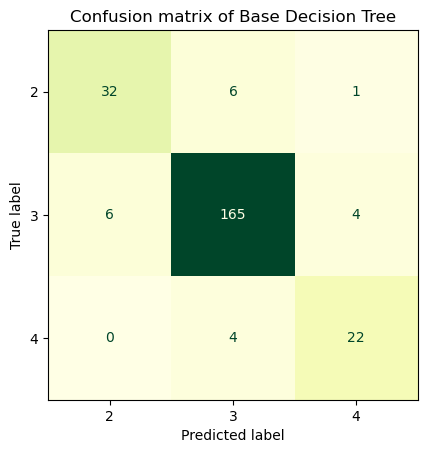

In [41]:
# Confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_model, X_test, y_test, colorbar= False, cmap= 'YlGn')
plt.title('Confusion matrix of Base Decision Tree')
plt.grid(False)

In [42]:
# classification report

print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           2       0.84      0.82      0.83        39
           3       0.94      0.94      0.94       175
           4       0.81      0.85      0.83        26

    accuracy                           0.91       240
   macro avg       0.87      0.87      0.87       240
weighted avg       0.91      0.91      0.91       240



In [40]:
# Performance metrics

'''Defining a function to calculate all the required performance metrics
for the given model'''
def metrics_calculator(y_test, y_pred, model_name):


  result= pd.DataFrame(data= [accuracy_score(y_test, y_pred),
                              precision_score(y_test, y_pred, average= 'macro'),
                              recall_score(y_test, y_pred, average= 'macro'),
                              f1_score(y_test, y_pred, average= 'macro')],
                       index=['Accuracy','precision','Recall', 'F1-score'],
                       columns= [model_name])
  return result


In [45]:
Base_dt_result= metrics_calculator(y_test, y_pred_dt, 'Base Decision Tree')
Base_dt_result.style.background_gradient(cmap='YlGn')

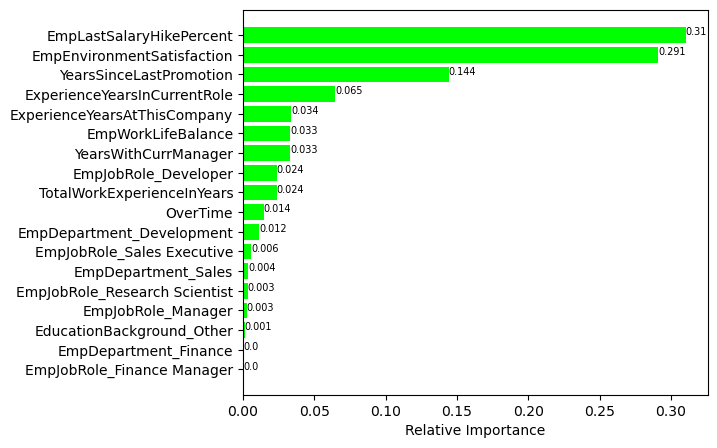

In [47]:
# feature importance

#getting feature importances from the decision tree model
importances= dt_model.feature_importances_
feature_names= X.columns

# sort the features by importance
indices= np.argsort(importances)

# Create a horizontal bar plot of the feature importances
plt.figure(figsize= (6, 5))
plt.barh(range(len(indices)), importances[indices], color= 'lime', align= 'center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')

# Add labels to the bars
for i, v in enumerate(importances[indices]):
  plt.text(v, i, str(round(v, 3)), color= 'black', fontsize= 7)

plt.show()

In [48]:
# saving base decision tree model as pkl file

import joblib
joblib.dump(dt_model,"trained_model_base_decision_tree.pkl")

['trained_model_base_decision_tree.pkl']

#### **TUNING DECISION TREE MODEL**

#### Finding optimal hyper parameters(GridSearchCV)

In [49]:
# model-->dt_model

# Defining evaluation
from sklearn.model_selection import RepeatedStratifiedKFold
cv= RepeatedStratifiedKFold(n_splits=10, n_repeats= 3, random_state= 0)

# Defining search parameters
max_depth= range(2, 19, 1)
criterion= ['entropy', 'gini']
min_samples_split= [2, 3, 4]
min_samples_leaf= [1, 2, 3]

param_grid= {'max_depth': max_depth, 'criterion': criterion, 'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf}

# Defining search
from sklearn.model_selection import GridSearchCV
search= GridSearchCV(dt_model, param_grid, scoring= 'accuracy', n_jobs= -1, cv= cv)

# Executing search
GridSearchCV = search.fit(X_train_sm, y_train_sm)

# Setting the classifier to the best combination of parameters
dt_model_cv= GridSearchCV.best_estimator_

# Summarizing the result
print('Best Score: ', GridSearchCV.best_score_)
print('Best hyperparameters: ', GridSearchCV.best_params_)


Best Score:  0.9443616617300826
Best hyperparameters:  {'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [50]:
# Training the tuned decision tree model

dt_model_cv.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier(max_depth=11)

In [51]:
# prediction

y_pred_tuned_dt= dt_model_cv.predict(X_test)

In [52]:
# Tuned model evaluation
# Accuracy score

print(f'Tuned DT model accuracy score:\n {accuracy_score(y_test, y_pred_tuned_dt)}')

Tuned DT model accuracy score:
 0.9083333333333333


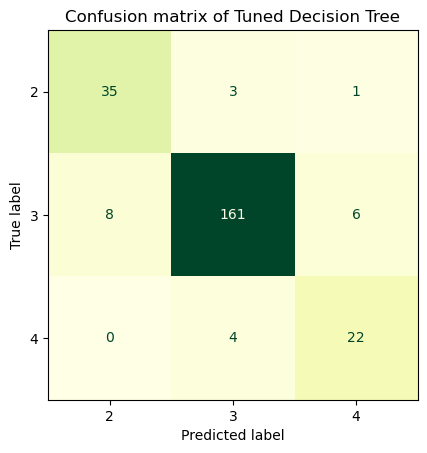

In [53]:
# Tuned model confusion matrix

ConfusionMatrixDisplay.from_estimator(dt_model_cv, X_test, y_test, colorbar= False, cmap= 'YlGn')
plt.title('Confusion matrix of Tuned Decision Tree')
plt.grid(False)


In [54]:
# tuned model classification report

print(classification_report(y_test, y_pred_tuned_dt))

              precision    recall  f1-score   support

           2       0.81      0.90      0.85        39
           3       0.96      0.92      0.94       175
           4       0.76      0.85      0.80        26

    accuracy                           0.91       240
   macro avg       0.84      0.89      0.86       240
weighted avg       0.91      0.91      0.91       240



In [55]:
# tuned model performance metrics

tuned_dt_result= metrics_calculator(y_test, y_pred_tuned_dt, 'Tuned Decision Tree')
tuned_dt_result.style.background_gradient(cmap='YlGn')

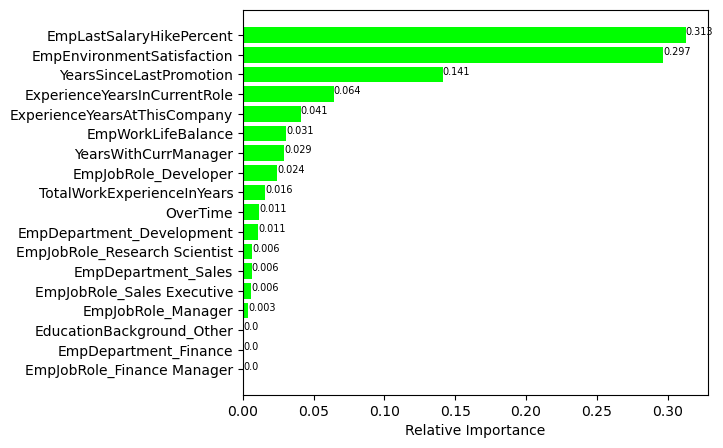

In [57]:
# tuned model feature importance

#getting feature importances from the tuned decision tree model
importances= dt_model_cv.feature_importances_
feature_names= X.columns

# sort the features by importance
indices= np.argsort(importances)

# Creating a horizontal bar plot of the feature importances
plt.figure(figsize= (6, 5))
plt.barh(range(len(indices)), importances[indices], color= 'lime', align= 'center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')

# Adding labels to the bars
for i, v in enumerate(importances[indices]):
  plt.text(v, i, str(round(v, 3)), color= 'black', fontsize= 7)

plt.show()

In [58]:
# saving tuned decision tree model as pkl file

import joblib
joblib.dump(dt_model_cv,"trained_model_tuned_decision_tree.pkl")

['trained_model_tuned_decision_tree.pkl']

#### **RANDOM FOREST:**

In [59]:
#Training the random forest model

# importing the model
from sklearn.ensemble import RandomForestClassifier

# Initializing the model
rf_model= RandomForestClassifier()

# fitting the model to the train data
rf_model.fit(X_train_sm, y_train_sm)

RandomForestClassifier()

In [60]:
# prediction

y_pred_rf= rf_model.predict(X_test)

In [61]:
# model evaluation

# Checking Accuracy score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
a= accuracy_score(y_test, y_pred_rf)
print(f'Model accuracy score: {a}')

Model accuracy score: 0.9375


In [62]:
# Checking for overfitting and underfitting

Training_accuracy= rf_model.score(X_train_sm, y_train_sm)
Testing_accuracy= rf_model.score(X_test, y_test)
print(f'Training set score: {Training_accuracy}')
print(f'Testing set score: {Testing_accuracy}')


Training set score: 1.0
Testing set score: 0.9375


The **training set accuracy** is **1.0** whereas the **testing set accuracy** is 0.93. Clearly the model is overfitted.

In [63]:
# K-Fold Cross-validation

from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
kf= KFold(n_splits= 10, shuffle= False)

In [64]:
# cross validation accuracy

score= cross_val_score(rf_model, X, y, cv= kf, scoring= 'accuracy')
print(f'Cross validation accuracy scores: {score}')

Cross validation accuracy scores: [0.875      0.98333333 0.94166667 0.93333333 0.975      0.96666667
 0.89166667 0.95       0.90833333 0.89166667]


In [65]:
RF_acc= pd.DataFrame({'CV mean': score.mean(), 'Std': score.std()}, index= ['Cross validation accuracy'])
RF_acc

CV mean       Std
Cross validation accuracy  0.931667  0.036286

- The **mean cross validation** of the model is 0.93 which shows that the model is expected to be around **93%** accurate on average.
- Hence it is evident that **10 fold cross validation** accuracy does not show any significant improvement in the model's performance.

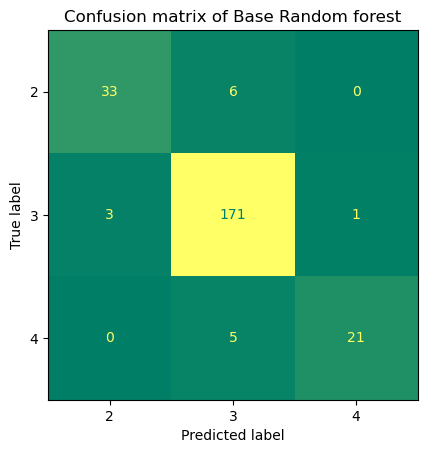

In [70]:
# Confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, colorbar= False, cmap= 'summer')
plt.title('Confusion matrix of Base Random forest')
plt.grid(False)

In [71]:
# classification report

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           2       0.92      0.85      0.88        39
           3       0.94      0.98      0.96       175
           4       0.95      0.81      0.88        26

    accuracy                           0.94       240
   macro avg       0.94      0.88      0.90       240
weighted avg       0.94      0.94      0.94       240



In [72]:
Base_rf_result= metrics_calculator(y_test, y_pred_rf, 'Base random forest')
Base_rf_result.style.background_gradient(cmap= 'summer')

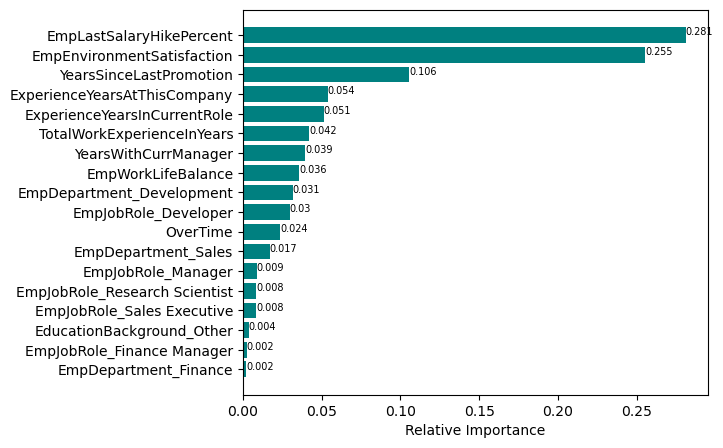

In [74]:
# Random Forest feature importance

#getting feature importances from the random forest model
importances= rf_model.feature_importances_
feature_names= X.columns

# sort the features by importance
indices= np.argsort(importances)

# Create a horizontal bar plot of the feature importances
plt.figure(figsize= (6, 5))
plt.barh(range(len(indices)), importances[indices], color= 'teal', align= 'center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')

# Add labels to the bars
for i, v in enumerate(importances[indices]):
  plt.text(v, i, str(round(v, 3)), color= 'black', fontsize= 7)

plt.show()

In [75]:
# saving random forest model as pkl file

import joblib
joblib.dump(rf_model,"trained_model_base_random_forest.pkl")

['trained_model_base_random_forest.pkl']

#### **TUNING RANDOM FOREST MODEL**

#### Finding optimal hyper parameters(GridSearchCV)

In [76]:
# model to be used--> rf_model

# Defining evaluation
from sklearn.model_selection import RepeatedStratifiedKFold
cv= RepeatedStratifiedKFold(n_splits=10, n_repeats= 3, random_state= 0)

# Defining search parameters
n_estimators= [10, 50, 100, 200]
max_depth= [None, 3, 4, 8, 9, 10, 11, 12]
criterion= ['entropy', 'gini']
max_features= ['sqrt', 'log2']
min_samples_split= [2, 5, 10]
min_samples_leaf= [1, 2, 4]


param_grid= {'n_estimators': n_estimators, 'max_depth': max_depth, 'criterion': criterion,\
             'max_features': max_features, 'min_samples_split': min_samples_split,\
             'min_samples_leaf':min_samples_leaf}

# Defining search
from sklearn.model_selection import GridSearchCV
search= GridSearchCV(rf_model, param_grid, scoring= 'accuracy', n_jobs= -1, cv= cv)

# Executing search
GridSearchCV = search.fit(X_train_sm, y_train_sm)

# Setting the classifier to the best combination of parameters
rf_model_cv= GridSearchCV.best_estimator_

# Summarizing the result
print('Best Score: ', GridSearchCV.best_score_)
print('Best hyperparameters: ', GridSearchCV.best_params_)



Best Score:  0.962646768436242
Best hyperparameters:  {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [77]:
# Training the tuned random forest model

rf_model_cv.fit(X_train_sm, y_train_sm)

RandomForestClassifier(criterion='entropy', n_estimators=200)

In [78]:
# prediction

y_pred_tuned_rf= rf_model_cv.predict(X_test)

In [79]:
# tuned model evaluation
# Accuracy score

print(f'Tuned RF model accuracy score:\n {accuracy_score(y_test, y_pred_tuned_rf)}')

Tuned RF model accuracy score:
 0.9333333333333333


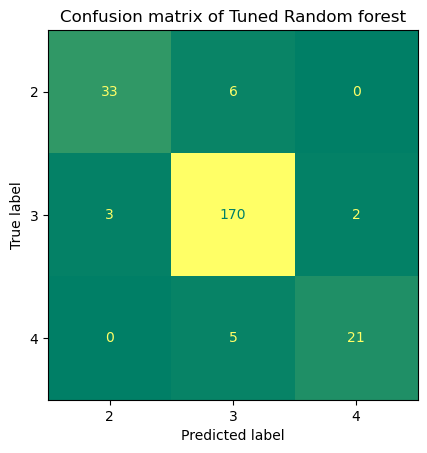

In [81]:
# Tuned model confusion matrix

ConfusionMatrixDisplay.from_estimator(rf_model_cv, X_test, y_test, colorbar= False, cmap= 'summer')
plt.title('Confusion matrix of Tuned Random forest')
plt.grid(False)

In [82]:
# classification report

print(classification_report(y_test, y_pred_tuned_rf))

              precision    recall  f1-score   support

           2       0.92      0.85      0.88        39
           3       0.94      0.97      0.96       175
           4       0.91      0.81      0.86        26

    accuracy                           0.93       240
   macro avg       0.92      0.88      0.90       240
weighted avg       0.93      0.93      0.93       240



In [83]:
# tuned model performance metrics

tuned_rf_result= metrics_calculator(y_test, y_pred_tuned_rf, 'Tuned Random Forest')
tuned_rf_result.style.background_gradient(cmap='summer')

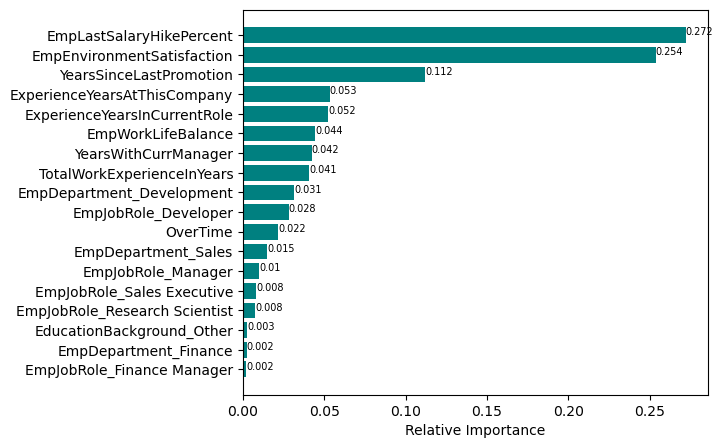

In [85]:
# tuned model feature importance

#getting feature importances from the tuned random forest model
importances= rf_model_cv.feature_importances_
feature_names= X.columns

# sort the features by importance
indices= np.argsort(importances)

# Creating a horizontal bar plot of the feature importances
plt.figure(figsize= (6, 5))
plt.barh(range(len(indices)), importances[indices], color= 'teal', align= 'center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')

# Adding labels to the bars
for i, v in enumerate(importances[indices]):
  plt.text(v, i, str(round(v, 3)), color= 'black', fontsize= 7)

plt.show()

In [86]:
# saving tuned random forest model as pkl file

import joblib
joblib.dump(rf_model_cv,"trained_model_tuned_random_forest.pkl")

['trained_model_tuned_random_forest.pkl']

#### **SUPPORT VECTOR MACHINE:**

In [30]:
# Training the model

# importing the model
from sklearn.svm import SVC

# Initiating the model
svm_model= SVC(probability = True)

# fitting the model to the training set
svm_model.fit(X_train_sm, y_train_sm)

SVC(probability=True)

In [31]:
# prediction

y_pred_svm= svm_model.predict(X_test)

In [32]:
# model evaluation

# Checking accuracy score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
print(f"Model accuracy score: {accuracy_score(y_test, y_pred_svm)}")

Model accuracy score: 0.7666666666666667


In [33]:
# Checking for overfitting and underfitting

Training_accuracy= svm_model.score(X_train_sm, y_train_sm)
Testing_accuracy= svm_model.score(X_test, y_test)
print(f'Training set score: {Training_accuracy}')
print(f'Testing set score: {Testing_accuracy}')

Training set score: 0.8502622794468288
Testing set score: 0.7666666666666667


#### Insights:
- The **training set** accuracy score is **0.850** while the **testing set** accuracy score is found to be **0.766**. thus the model is overfitted.

In [34]:
# K-Fold Cross-validation

from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
kf= KFold(n_splits= 10, shuffle= False)

In [35]:
# cross validation accuracy

score= cross_val_score(svm_model, X, y, cv= kf, scoring= 'accuracy')
print(f'Cross validation accuracy scores: {score}')

Cross validation accuracy scores: [0.90833333 0.75       0.73333333 0.69166667 0.71666667 0.68333333
 0.725      0.81666667 0.85       0.775     ]


In [36]:
SVM_acc= pd.DataFrame({'CV mean': score.mean(), 'Std': score.std()}, index= ['Cross validation accuracy'])
SVM_acc

CV mean       Std
Cross validation accuracy    0.765  0.069101

#### Interpretation:
- The **mean cross validation** of the model is 0.765 which shows that the model is expected to be around **76.5%** accurate on average.
- Hence it is evident that **10 fold cross validation** accuracy does not show any significant improvement in the model's performance.

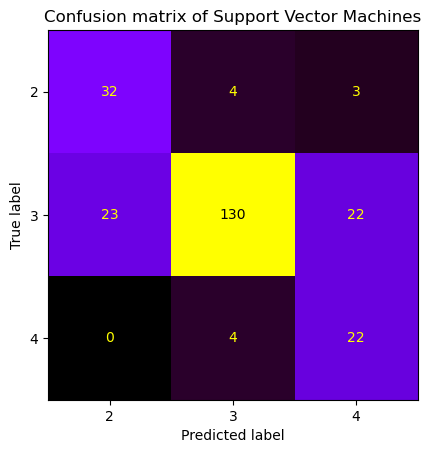

In [37]:
# Confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test, colorbar= False, cmap= 'gnuplot')
plt.title('Confusion matrix of Support Vector Machines')
plt.grid(False)

In [38]:
# classification report

print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           2       0.58      0.82      0.68        39
           3       0.94      0.74      0.83       175
           4       0.47      0.85      0.60        26

    accuracy                           0.77       240
   macro avg       0.66      0.80      0.70       240
weighted avg       0.83      0.77      0.78       240



In [41]:
Base_svm_result= metrics_calculator(y_test, y_pred_svm, 'Base SVM')
Base_svm_result.style.background_gradient(cmap='gnuplot')

In [42]:
# saving base support vector machine model as pkl file

import joblib
joblib.dump(svm_model,"trained_model_base_svm.pkl")

['trained_model_base_svm.pkl']

#### **TUNING SVM MODEL**

#### Finding optimal hyper parameters(gridSearchCV)

In [43]:
# model--> svm_model

# Defining search parameters
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter 
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf' kernel
}

# Defining search
from sklearn.model_selection import GridSearchCV
search= GridSearchCV(svm_model, param_grid, scoring= 'accuracy', n_jobs= -1, cv= 5)

# Executing search
GridSearchCV = search.fit(X_train_sm, y_train_sm)

# Setting the classifier to the best combination of parameters
svm_model_cv= GridSearchCV.best_estimator_

# Summarizing the result
print('Best Score: ', GridSearchCV.best_score_)
print('Best hyperparameters: ', GridSearchCV.best_params_)

Best Score:  0.9437390612569609
Best hyperparameters:  {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [44]:
# Training the tuned svm model
svm_model_cv.fit(X_train_sm, y_train_sm)

SVC(C=10, gamma='auto', probability=True)

In [45]:
# prediction

y_pred_tuned_svm= svm_model_cv.predict(X_test)

In [46]:
# tuned model evaluation
# Accuracy score

print(f'Tuned SVM model accuracy score:\n {accuracy_score(y_test, y_pred_tuned_svm)}')

Tuned SVM model accuracy score:
 0.8666666666666667


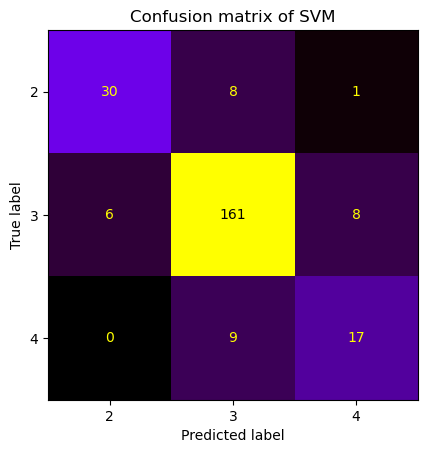

In [48]:
# Tuned model confusion matrix

ConfusionMatrixDisplay.from_estimator(svm_model_cv, X_test, y_test, colorbar= False, cmap= 'gnuplot')
plt.title('Confusion matrix of SVM')
plt.grid(False)

In [49]:
# tuned model classification report

print(classification_report(y_test, y_pred_tuned_svm))

              precision    recall  f1-score   support

           2       0.83      0.77      0.80        39
           3       0.90      0.92      0.91       175
           4       0.65      0.65      0.65        26

    accuracy                           0.87       240
   macro avg       0.80      0.78      0.79       240
weighted avg       0.87      0.87      0.87       240



In [50]:
# tuned model performance metrics

tuned_svm_result= metrics_calculator(y_test, y_pred_tuned_svm, 'Tuned SVM')
tuned_svm_result.style.background_gradient(cmap= 'gnuplot')

In [51]:
# saving tuned svm model as pkl file

import joblib
joblib.dump(svm_model_cv,"trained_model_tuned_svm.pkl")

['trained_model_tuned_svm.pkl']

#### **TUNED XG BOOSTING**

In [53]:
# importing the model
import xgboost as xg

# label encoding the target variable to have values of 0, 1, 2 of performance rating to have easy model implementation
from sklearn.preprocessing import LabelEncoder
label_encoder_xgboost = LabelEncoder()
y_train_sm_encoded = label_encoder_xgboost.fit_transform(y_train_sm)

# creating xgboost classfier
xgboost= xg.XGBClassifier(objective= 'multi:softmax', learning_rate= 0.1)


# Defining a dictionary of hyperparameters to tune
param_grid= {'n_estimators': [50, 100],
             'max_depth': [5, 7],
             'learning_rate': [0.01, 0.1],
             'subsample': [0.6, 0.8, 1],
             'colsample_bytree': [0.6, 0.8, 1.0],
             'gamma': [0, 1, 5]}

# Defining search
from sklearn.model_selection import GridSearchCV
search= GridSearchCV(estimator= xgboost, param_grid= param_grid, scoring= 'accuracy', n_jobs= -1, cv= 10)

# executing the search
GridSearchCV= search.fit(X_train_sm, y_train_sm_encoded)

# Setting the classifier to the best combination of parameters
xg_boost_model_cv= GridSearchCV.best_estimator_

# Summarizing the result
print('Best Score: ', GridSearchCV.best_score_)
print('Best hyperparameters:', GridSearchCV.best_params_)

Best Score:  0.9647095010252904
Best hyperparameters: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


In [54]:
# training the tuned model

# fitting the extreme gradient boosting model on the training set
xg_boost_model_cv.fit(X_train_sm, y_train_sm_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [55]:
# prediction

y_pred_tuned_xgboost= xg_boost_model_cv.predict(X_test)

In [56]:
# model evaluation

# Encoding y_test data to have 0, 1, 2 orders of performance rating
y_test_encoded = label_encoder_xgboost.transform(y_test)


#accuracy score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
a= accuracy_score(y_test_encoded, y_pred_tuned_xgboost)
print(f'Accuracy score of the XG boost model: {a}')

Accuracy score of the XG boost model: 0.9333333333333333


In [59]:
# cross validated score

from sklearn.model_selection import cross_val_score
cross_val_scores= cross_val_score(xg_boost_model_cv, X_train_sm, y_train_sm_encoded, cv= 10, scoring= 'accuracy')

print('Cross-validated score of the XG Boost Model:', cross_val_scores.mean())

Cross-validated score of the XG Boost Model: 0.9647095010252904


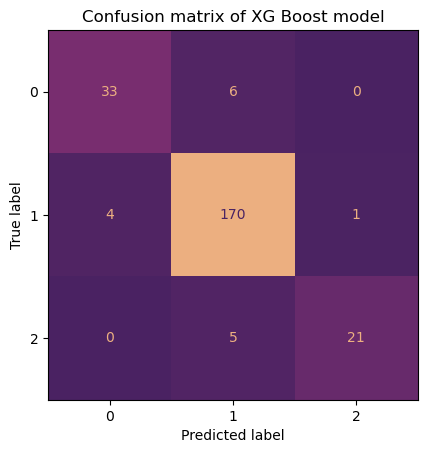

In [70]:
# Tuned model confusion matrix

ConfusionMatrixDisplay.from_estimator(xg_boost_model_cv, X_test, y_test_encoded, colorbar= False, cmap= 'flare_r')
plt.title('Confusion matrix of XG Boost model')
plt.grid(False)

In [71]:
# tuned model classification report

print(classification_report(y_test_encoded, y_pred_tuned_xgboost))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87        39
           1       0.94      0.97      0.96       175
           2       0.95      0.81      0.88        26

    accuracy                           0.93       240
   macro avg       0.93      0.88      0.90       240
weighted avg       0.93      0.93      0.93       240



In [72]:
xg_boost_result= metrics_calculator(y_test_encoded, y_pred_tuned_xgboost, 'Tuned XGBoost')
xg_boost_result.style.background_gradient(cmap='flare_r')

In [73]:
# saving tuned xg boost model as pkl file

import joblib
joblib.dump(xg_boost_model_cv,"trained_model_tuned_xgboost.pkl")

['trained_model_tuned_xgboost.pkl']

### For more information, See Reference Directory